# Programming Exercise 2: Classification using Logistic Regression and Neural Networks

> In this exercise, you will implement logistic regression and apply it to two different datasets.

## 1. Logistic Regression

A video game designer is trying to find a way to dynamically calibrate the difficulty of a final "boss fight" at the end of a level.  

The particular task is to use scores from two previous challenges to determine if a player is likely to pass the final challenge.

Player testing has provided a data set.
The data contains for each player, the player's two scores and whether or not the final challenge was completed successfully.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#pip install torch
import os
print(os.getcwd())

/Users/juliansutaria


In [3]:
import torch

## 1.1 Load the data and visualize

We will interface with the data in a similar fashion to Exercise 1.

The input data file `ex2data.txt` can be downloaded from this [link](https://drive.google.com/file/d/1ox7K4_wSqvUPgPyIDB3GwoFGFTQNIbPi/view?usp=drive_link).

As this is a co-lab notebook, we assume that the file has been uploaded to `/content/sample_data/`. Use the folder button on the left-hand side to navigate the instance's file system folders.

In [4]:
# we use numpy's import function
from numpy import genfromtxt
data = genfromtxt('/Users/juliansutaria/Downloads/untitled folder 2/ex2data1.txt', delimiter=',')

print("shape of numpy array (expected to be (100,3)): ",data.shape)

shape of numpy array (expected to be (100,3)):  (100, 3)


(100,)
(60, 2)
(40, 2)


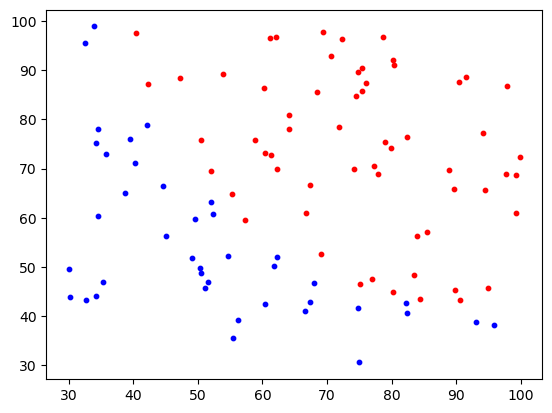

In [6]:
# let's plot the data for the two classes.

# first we need to separate the score of passing players from non-passing players
# we can create an array with each row being true or false based on the flag

# slice out the 3rd column, indicating if passed (=1) or failed(=0)
boss_result = data[:,2] # I want all the rows (:) but only the second column
print(boss_result.shape)

player_passed = boss_result==1 # this test is run on each row of boss_result

# now we can filter the scores for the passing players
passing_scores = data[player_passed[:],:2] # select only rows for passing players
print(passing_scores.shape)

# and the scores for the failing players
failing_scores = data[~player_passed[:],:2] # selet rows for failing players
print(failing_scores.shape)

plt.scatter(passing_scores[:,0], passing_scores[:,1], s=10, c='r')
plt.scatter(failing_scores[:,0], failing_scores[:,1], s=10, c='b')
plt.show()

torch.Size([100, 1])


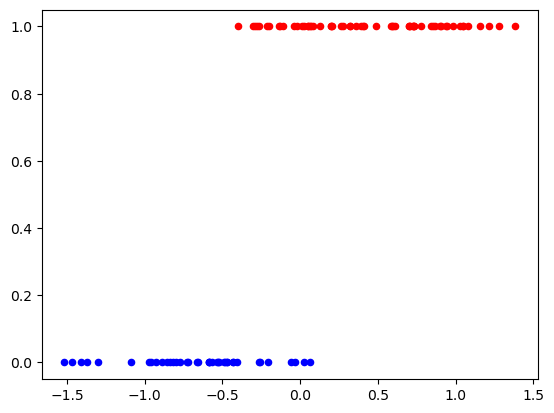

In [21]:
# 1D Logistic regression
# to start, we can turn this into a 1D logistic regression problem

# Add the numbers together
score1 = (data[:,0]-np.mean(data[:,0]))/np.std(data[:,0])
score2 = (data[:,1]-np.mean(data[:,1]))/np.std(data[:,1])
# result = torch.from_numpy(data[:,2])
result = torch.tensor(data[:,2], dtype=torch.float32)
result = result.unsqueeze(1)
print(result.shape)

ave_score = 0.5*(score1 + score2)
# print(ave_score.shape)
# print(result.shape)

ave_score_passing = ave_score[player_passed]
ave_score_failing = ave_score[~player_passed]
result_passing = result[player_passed]
result_failing = result[~player_passed]

plt.scatter(ave_score_passing, result_passing, s=20, c='r')
plt.scatter(ave_score_failing, result_failing, s=20, c='b')
plt.show()


In [5]:
def logistic_fn( x, theta):
  score = theta[0] + theta[1]*x
  return 1.0/(1+np.exp(-score))


In [8]:
# eyeballing values
th = np.array((-65.0, 1.0))
print(th.shape)
pred = logistic_fn(ave_score, th)
print(pred.shape)

(2,)
(100,)


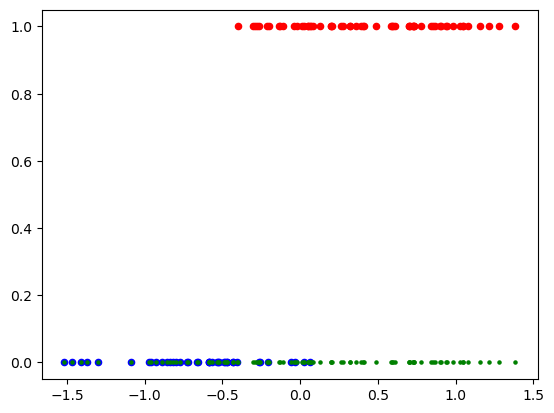

In [8]:
plt.scatter(ave_score_passing, result_passing, s=20, c='r')
plt.scatter(ave_score_failing, result_failing, s=20, c='b')
plt.scatter(ave_score, pred, s=5, c='g')
plt.show()


In [33]:
# torch has similar functions for array as numpy -- with some even sharing the same name

# def predict_torch(X_, th_):
#   res = torch.matmul(X_.T,th_)
#   # print(res.shape)
#   return 1 / (1 + torch.exp(-res))

# def calc_loss_torch( X_train, Y_true, th ):
#   y_pred = predict_torch(X_train,th)
#   loss = (torch.matmul(-Y_true,torch.log(y_pred)) - torch.matmul((1-Y_true),torch.log(1-y_pred)))
#   return loss

def predict_torch(X_, th_):
  res = torch.matmul(torch.transpose(X_, 1, 0),th_)
  return 1.0 / (1.0 + torch.exp(-res))

def calc_loss_torch( X_train, Y_true, th ):
  y_pred = predict_torch(X_train,th)
  # print(y_pred)
  #y_pred = torch.clamp(y_pred, 1e-7, 1 - 1e-7)
  # loss = torch.binary_cross_entropy_with_logits()
  l = -torch.mean(Y_true*torch.log(y_pred) + (1.0-Y_true)*torch.log(1-y_pred))
  return l

# try it out
# loss = calc_loss_torch(X_t, Y_t, th_t)
# print(loss)

In [34]:
n_steps = 8000
lr = 1.0e-2

X = torch.from_numpy(np.vstack((np.ones(len(ave_score)), ave_score)))
#print(X)
theta = np.random.random((2,1))
th_t = torch.tensor(theta, requires_grad=True)
print("initial theta: " + str(th_t))
th_track = np.zeros((n_steps+1,2))
th_track[0,:] = theta.T
loss_track = np.zeros(n_steps)

for i in range(0,n_steps):
    # print(th_t.grad)
    loss = calc_loss_torch(X, result, th_t)
    loss.backward()

    with torch.no_grad():
        # print(th_t.grad)
        th_t -= lr*th_t.grad
        th_track[i+1,:] = th_t.detach().numpy().T
        loss_track[i] = loss.item()
        th_t.grad.zero_()

print("Final Answer: " +str(th_t))

initial theta: tensor([[0.3697],
        [0.8099]], dtype=torch.float64, requires_grad=True)
Final Answer: tensor([[1.0036],
        [4.5413]], dtype=torch.float64, requires_grad=True)


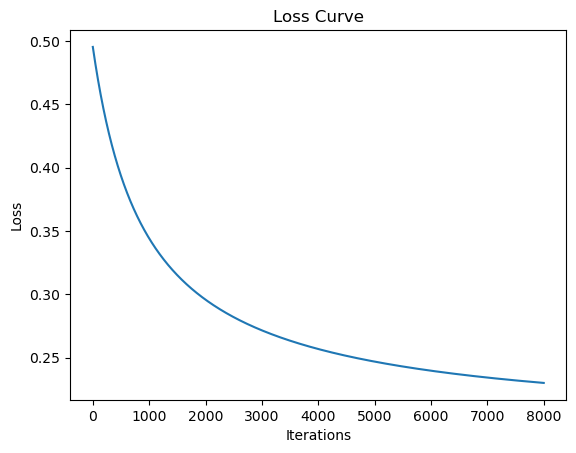

In [35]:
plt.plot(loss_track)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

tensor([-0.4820, -1.5169, -0.5889,  0.4021,  0.5925, -0.7989,  0.7019, -0.2896,
         0.8432, -0.1283,  0.0233, -0.7212,  0.7078,  0.9478, -0.4088,  0.3201,
        -0.2761, -0.4690,  0.8517, -0.2115, -0.5877,  0.6092, -0.8598, -1.4070,
         0.3915,  0.0138, -0.2031, -0.0321, -0.5303, -0.7268,  0.0680,  0.2623,
        -0.4333, -0.2644, -0.5224, -0.6631,  0.0634,  0.3592, -0.4304, -0.5687,
         0.2034, -0.8877,  0.7261, -0.2605, -0.9286, -0.4713,  0.4128,  1.3842,
         0.7338,  1.2772,  0.5841,  0.7272,  0.0257, -0.9612, -0.8406, -0.5881,
         0.8978, -0.0596,  0.3196,  0.4897,  0.7802, -1.3033, -0.9716, -1.3687,
        -0.5355, -0.6559,  0.1963, -0.8157,  1.0782, -0.1130, -1.4699,  0.2779,
         0.9845,  0.0519,  0.0849,  1.0490,  0.1271, -0.1329, -0.7753, -0.2073,
         0.6978,  0.1987,  0.0532, -0.3985,  1.0492,  0.5968, -0.2673,  0.9084,
         1.1583, -0.4908,  1.0305,  1.2162, -1.0913,  0.7321,  0.0608, -0.0216,
        -0.0392,  0.9386, -0.3010,  0.86

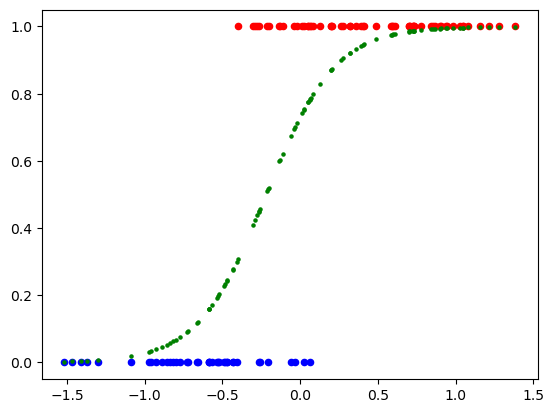

In [36]:
# th_t = torch.tensor([[1.7], [5.4]], dtype=torch.double)
pred = predict_torch(X, th_t)
print(X[1,:])
print(result)

plt.scatter(ave_score_passing, result_passing, s=20, c='r')
plt.scatter(ave_score_failing, result_failing, s=20, c='b')
plt.scatter(ave_score, pred.detach().numpy(), s=5, c='g')
plt.show()

In [131]:
print(X[1,:])

tensor([-0.4820, -1.5169, -0.5889,  0.4021,  0.5925, -0.7989,  0.7019, -0.2896,
         0.8432, -0.1283,  0.0233, -0.7212,  0.7078,  0.9478, -0.4088,  0.3201,
        -0.2761, -0.4690,  0.8517, -0.2115, -0.5877,  0.6092, -0.8598, -1.4070,
         0.3915,  0.0138, -0.2031, -0.0321, -0.5303, -0.7268,  0.0680,  0.2623,
        -0.4333, -0.2644, -0.5224, -0.6631,  0.0634,  0.3592, -0.4304, -0.5687,
         0.2034, -0.8877,  0.7261, -0.2605, -0.9286, -0.4713,  0.4128,  1.3842,
         0.7338,  1.2772,  0.5841,  0.7272,  0.0257, -0.9612, -0.8406, -0.5881,
         0.8978, -0.0596,  0.3196,  0.4897,  0.7802, -1.3033, -0.9716, -1.3687,
        -0.5355, -0.6559,  0.1963, -0.8157,  1.0782, -0.1130, -1.4699,  0.2779,
         0.9845,  0.0519,  0.0849,  1.0490,  0.1271, -0.1329, -0.7753, -0.2073,
         0.6978,  0.1987,  0.0532, -0.3985,  1.0492,  0.5968, -0.2673,  0.9084,
         1.1583, -0.4908,  1.0305,  1.2162, -1.0913,  0.7321,  0.0608, -0.0216,
        -0.0392,  0.9386, -0.3010,  0.86

## 2. Regularized Logistic Regression

> In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assur- ance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.
Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.


The input data file `ex2data2.txt` can be downloaded from this [link]().

As this is a co-lab notebook, we assume that the file has been uploaded to `/content/sample_data/`. Use the folder button on the left-hand side to navigate the instance's file system folders.
### 2.1 Visualizing the Data

You can see that a simple line is not a good model for regressing the data.

In [88]:
# we use numpy's import function
from numpy import genfromtxt
data2 = genfromtxt('/Users/juliansutaria/Downloads/untitled folder 2/ex2data2.txt', delimiter=',')

print("shape of numpy array (expected to be (100,3)): ",data.shape)

shape of numpy array (expected to be (100,3)):  (100, 3)


(118,)
(60, 2)
(60, 2)


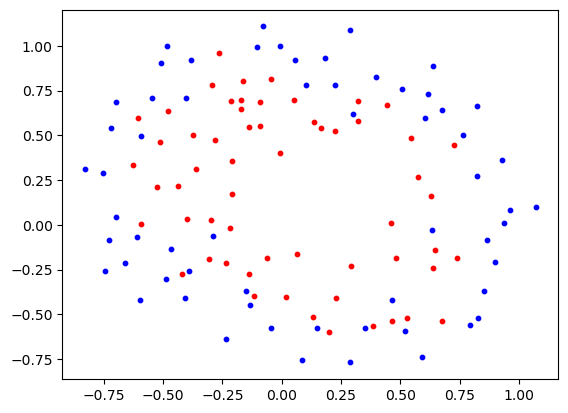

In [89]:
# slice out the 3rd column, indicating if passed (=1) or failed(=0)
chip_result = data2[:,2] # I want all the rows (:) but only the second column
print(chip_result.shape)

chip_passed = chip_result==1 # this test is run on each row of boss_result

# now we can filter the scores for the passing players
chip_passing_scores = data2[chip_passed[:],:2] # select only rows for passing players
print(passing_scores.shape)

# and the scores for the failing players
chip_failing_scores = data2[~chip_passed[:],:2] # selet rows for failing players
print(chip_failing_scores.shape)

plt.scatter(chip_passing_scores[:,0], chip_passing_scores[:,1], s=10, c='r')
plt.scatter(chip_failing_scores[:,0], chip_failing_scores[:,1], s=10, c='b')
plt.show()

### 2.2 Feature Mapping

> One way to fit the data better is to create more features from each data point. We will map the features into all polynomial terms of $x_1$ and $x_2$ up to the sixth power. As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classifier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.

## 2.2 Regularization

Because we have so many parameters now, we add to the loss function some terms based on the parameter values.

One common regularization is to add a loss term to keep the values small.

Add to the loss function the sum of the parameter values squared -- this wants to keep the value of each parameter near zero.

Another is to add the sum of the absolute value of each parameter to the loss function.  This has a slighly different effect, which is to keep the parameter values sparse: the number of parameters with large values is kept low.

## Neural nework classification

If you get to it, you can try a neural network. But we'll cover this next Tuesday -- and then start our projects.